In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Loading the data
First we try loading the small data and see what we can discover.

In [2]:
df_oil = pd.read_csv("oil.csv")
df_items = pd.read_csv("items.csv")
df_stores = pd.read_csv("stores.csv")
df_holidays_events = pd.read_csv("holidays_events.csv")

## Oil

In [3]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
print(df_oil.memory_usage(index=True).sum()/ 1024, "KB")

19.109375 KB


In [5]:
print("NaNs: ", df_oil[["dcoilwtico"]].isnull().sum()[0])
print("Total: ", df_oil[["dcoilwtico"]].count()[0])

NaNs:  43
Total:  1175


Seems like there are some incomplete entries in the oil file - let's just forward fill then backward fill to fill in the gaps.

In [6]:
df_oil = df_oil.ffill().bfill()

In [7]:
df_oil["dcoilwtico"] = df_oil["dcoilwtico"] * 100

In [8]:
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].astype(int)
print(df_oil.memory_usage(index=True).sum()/ 1024, "KB")

19.109375 KB


Also, the oil data ends at 8/31/2017 - meaning that to make a meaningful future projecting model we might need to scrape oil prices.

### Oil graph over time

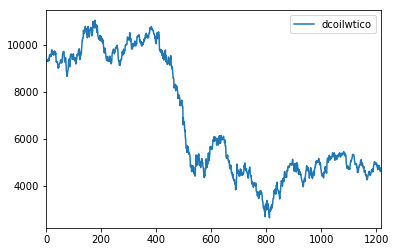

In [9]:
df_oil.plot()
plt.show()

### Oil graph - weekly moving average

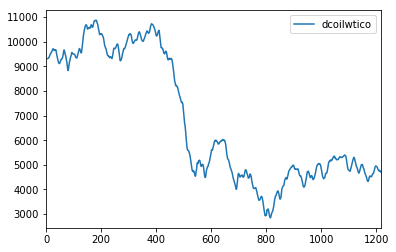

In [10]:
df_oil.rolling(window=7, center=False).mean().plot()
plt.show()

### Oil graph - first order weekly "derivative"

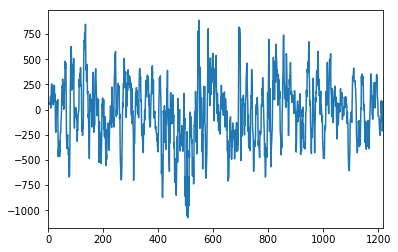

In [11]:
df_oil["dcoilwtico"].diff(7).plot()
plt.show()

### Oil graph - first order weekly "derivative", monthly moving average

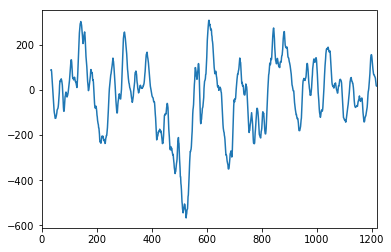

In [12]:
df_oil["dcoilwtico"].diff(7).rolling(window=28, center=False).mean().plot()
plt.show()

## Items

In [13]:
print(df_items.memory_usage(index=True).sum()/ 1024, "KB")
df_items.head()

128.203125 KB


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [14]:
df_items["item_nbr"].unique().size

4100

In [15]:
df_items["family"].unique().size

33

In [16]:
df_items["class"].unique().size

337

Given these data types, we can drastically reduce the representation of items. uint8 is enough for family, which we feed through an encoder, whereas uint16 is enough for the rest (which we feed through their own encoders).

In [17]:
items_le = preprocessing.LabelEncoder()
df_items["item_nbr"] = items_le.fit_transform(df_items["item_nbr"]).astype("uint16")

family_le = preprocessing.LabelEncoder()
df_items["family"] = family_le.fit_transform(df_items["family"]).astype("uint8")

class_le = preprocessing.LabelEncoder()
df_items["class"] = class_le.fit_transform(df_items["class"]).astype("uint16")

df_items["perishable"] = df_items["perishable"].astype(bool)

In [18]:
print(df_items.memory_usage(index=True).sum()/ 1024, "KB")
df_items.head()

24.1015625 KB


,item_nbr,family,class,perishable
0,0,12,64,False
1,1,12,44,False
2,2,7,217,False
3,3,12,17,False
4,4,5,187,True


We shrunk the whole dataframe by almost five times! This might seem insignificant for such a tiny file, but since item number is used in the big train dataframe, this can come in handy later.

## Stores

In [19]:
print(df_stores.memory_usage(index=True).sum()/ 1024, "KB")
df_stores.head()

2.1875 KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
print(df_stores["store_nbr"].unique().size, 
     df_stores["city"].unique().size,
     df_stores["state"].unique().size,
     df_stores["type"].unique().size,
     df_stores["cluster"].unique().size)

54 22 16 5 17


Seems like quite a few of these are categorical, and have few unique values. Perhaps something to keep in mind when we perhaps use Catboost later on.

In [21]:
df_stores["store_nbr"] = df_stores["store_nbr"].astype("uint8")

city_le = preprocessing.LabelEncoder()
df_stores["city"] = city_le.fit_transform(df_stores["city"]).astype("uint8")

state_le = preprocessing.LabelEncoder()
df_stores["state"] = state_le.fit_transform(df_stores["state"]).astype("uint8")

type_le = preprocessing.LabelEncoder()
df_stores["type"] = type_le.fit_transform(df_stores["type"]).astype("uint8")

cluster_le = preprocessing.LabelEncoder()
df_stores["cluster"] = cluster_le.fit_transform(df_stores["cluster"]).astype("uint8")

In [22]:
print(df_stores.memory_usage(index=True).sum()/ 1024, "KB")
df_stores.head()

0.341796875 KB


,store_nbr,city,state,type,cluster
0,1,18,12,3,12
1,2,18,12,3,12
2,3,18,12,3,7
3,4,18,12,3,8
4,5,21,14,3,3


Again, massive 7 fold decrease.

## Holidays and Events

In [23]:
print(df_holidays_events.memory_usage(index=True).sum()/ 1024, "KB")
df_holidays_events.head()

14.091796875 KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Train.csv

In [24]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }

In [25]:
train_part2=pd.read_csv("./train.csv",dtype=dtype_dict,usecols=[1,5],parse_dates=[0])
train_part2['Year'] = pd.DatetimeIndex(train_part2['date']).year - 2000
train_part2['Month'] = pd.DatetimeIndex(train_part2['date']).month
train_part2['Day'] =pd.DatetimeIndex(train_part2['date']).day
train_part2['Weekday'] =pd.DatetimeIndex(train_part2['date']).weekday
del(train_part2['date'])
train_part2['Day']=train_part2['Day'].astype(np.uint8)
train_part2['Month']=train_part2['Month'].astype(np.uint8)
train_part2['Year']=train_part2['Year'].astype(np.uint8)
train_part2['Weekday']=train_part2['Weekday'].astype(np.uint8)

train_part2["onpromotion"].fillna(0, inplace=True)
train_part2["onpromotion"]=train_part2["onpromotion"].astype(np.uint8)

print(train_part2.head())

/home/joseph/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   onpromotion  Year  Month  Day  Weekday
0            0    13      1    1        1
1            0    13      1    1        1
2            0    13      1    1        1
3            0    13      1    1        1
4            0    13      1    1        1


In [26]:
train_part1 = pd.read_csv("./train.csv",dtype=dtype_dict,usecols=[2,3,4])

In [27]:
train_part1["item_nbr"] = items_le.fit_transform(train_part1["item_nbr"]).astype("uint16")

In [28]:
train = pd.concat([train_part1.reset_index(drop=True), train_part2], axis=1)

In [29]:
del(train_part1)
del(train_part2)

In [30]:

new_mem_train=train.memory_usage().sum()
print("Train dataset uses ", new_mem_train/ 1024**2," MB after changes")

Train dataset uses  1436.199722290039  MB after changes


In [31]:
train.dtypes

store_nbr        uint8
item_nbr        uint16
unit_sales     float32
onpromotion      uint8
Year             uint8
Month            uint8
Day              uint8
Weekday          uint8
dtype: object

In [32]:
train.to_pickle('train_pickle.pkl')